**En este notebook hay funcionalides de Theano que ya se separarán convenientemente.**

In [2]:
import numpy as np
import theano
import theano.tensor as T

##  Computar más de una cosa en el mismo tiempo.

Theano soporta funciones con múltiple outputs.

In [10]:
# Definimos las matrices
a, b = T.dmatrices('a', 'b')
# Definimos las función simbolicamente
diff = a - b
abs_diff = abs(diff)
diff_square = diff**2
# Definimos la función para theano con diferentes outputs
f = theano.function([a,b], [diff, abs_diff, diff_square])
# Definimos el array de entrada con Numpy
a = np.array([[1, 1], [1, 1]])
b = np.array([[0, 1], [2, 3]])
f(a,b)

[array([[ 1.,  0.],
        [-1., -2.]]), array([[ 1.,  0.],
        [ 1.,  2.]]), array([[ 1.,  0.],
        [ 1.,  4.]])]

## Colocar un valor por defecto como argumento de entrada a una función.

In [14]:
# Definimos los escalares
x, y = T.dscalars('x', 'y')
# Definimos la función simbolicamente
z = x + y
# Definimos la función para theano
f = theano.function([x, theano.Param(y, default=0)], z)
# LLamamos a la función con un único parámetro de entrada
# ya que el otro se introduce como argumento default.
f(33)
# Si introducimos el segundo valor actua en la función
f(33,5)

array(38.0)

## Usando variables globales

In [20]:
state = theano.shared(0)
inc = T.iscalar('inc')
accumulator = theano.function([inc], state, updates=[(state, state+inc)])

In [23]:
print state.get_value()
print accumulator(1)
print state.get_value()

1
1
2


## Usundo números aleatorios

In [26]:
from theano.tensor.shared_randomstreams import RandomStreams
srng = RandomStreams(seed=234)
rv_u = srng.uniform((2,2))
rv_n = srng.normal((2,2))

In [27]:
rv_n

RandomFunction{normal}.1

In [ ]:
Falta

## Scan

$$A^{k}$$

In [139]:
k = T.iscalar("K")
A = T.vector("A")

# Descripción simbólica de los resultados
result, updates = theano.scan(fn=lambda prior_result, A: prior_result*A,
                             outputs_info=T.ones_like(A),
                             non_sequences=A,
                             n_steps=k)
final_result = result[-1]

# compiled function that returns A**k
power = theano.function(inputs=[A,k], outputs=final_result, updates=updates)

print power(range(10),2)
print power(range(10),4)

[  0.   1.   4.   9.  16.  25.  36.  49.  64.  81.]
[  0.00000000e+00   1.00000000e+00   1.60000000e+01   8.10000000e+01
   2.56000000e+02   6.25000000e+02   1.29600000e+03   2.40100000e+03
   4.09600000e+03   6.56100000e+03]


## Cálculos de gradiente

Theano permite calcular gradientes de forma simbólica definiendo una función y calcularla numericamente.

$${\rm I\!R} \longrightarrow {\rm I\!R}^{n}$$

Cálculo del gradiente de la función: $f(x,y) = 1 - (x^{2} + y^{2})$.

Gradiente: $\nabla f(x,y) = (\frac{\partial f}{\partial x},\frac{\partial f}{\partial y}) = (-2x, -2y)$

Gradiente en un punto: $\nabla f(x_{0},y_{0}) =  (-2x_{0}, -2y_{0})$

* Representamos la función y calculamos el gradiente a papel y lapiz, luego se propone un punto y se representa.

<matplotlib.colorbar.Colorbar instance at 0x10e5861b8>

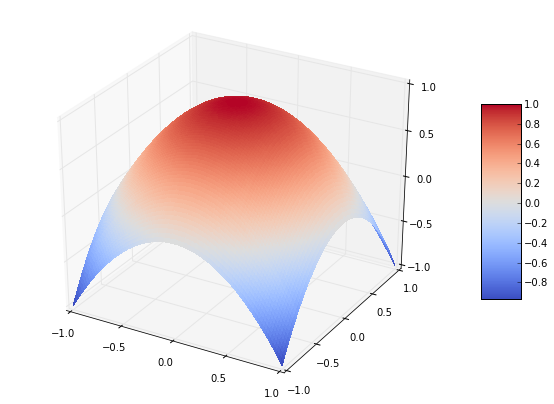

In [38]:
%matplotlib inline
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,7))
ax = fig.gca(projection='3d')
# Se define los ejes X y Y
X = np.linspace(-1,1,100)
Y = np.linspace(-1,1,100)
# Se define la malla
X, Y = np.meshgrid(X, Y)
# Se define la función
Z = 1 - (X**2 + Y**2)
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

fig.colorbar(surf, shrink=0.5, aspect=5)

<matplotlib.contour.QuadContourSet instance at 0x10e7d7050>

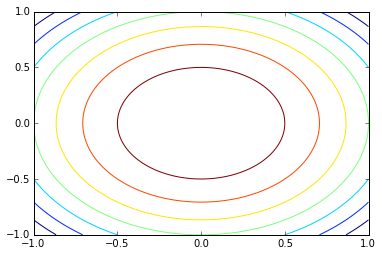

In [66]:
plt.contour(X, Y, Z)

In [122]:
def gradiente(x,y):
    return -2*x, -2*y
point = gradiente(-0.1, 0)
point

(0.2, 0)

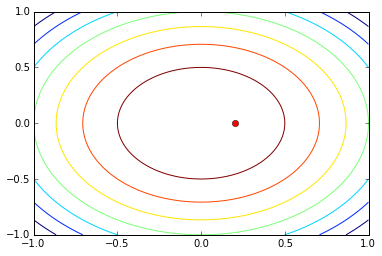

In [127]:
plt.contour(X, Y, Z)
plt.plot(point[0], point[1], "ro")

* Realizamos la misma operación con Theano

In [125]:
import theano
import theano.tensor as T
from theano import pp
# Se define las variables
x = T.dscalar('x')
y = T.dscalar('y')
# Se define lafunción
f = 1 - (x**2 + y**2)
# Se define el gradiente de la función
gz = T.grad(f, [x,y])  # f respecto a x y f respecto a y
 
# Se define la función para theano
f = theano.function([x,y],gz)
# Se pide los valores a la función de theano
theanoPoint = f(-0.1,0)
theanoPoint

[array(0.2), array(-0.0)]

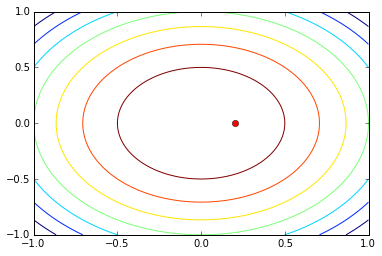

In [124]:
plt.contour(X, Y, Z)
plt.plot(theanoPoint[0], theanoPoint[1], "ro")

## Cálculo del Jacobiano --> falta

Representa la devirada de una función multivariable.

http://deeplearning.net/software/theano/tutorial/gradients.html

**Forma escalar**

$$f: {\rm I\!R}^{n} \longrightarrow {\rm I\!R}$$

en este caso el *Jacobiano* será una matriz formada por un vector fila que coincide con el gradiente.

**Forma vectorial**

$$f: {\rm I\!R}^{n} \longrightarrow {\rm I\!R}^{n}$$

Es una función que va del espacio euclídeo n-dimensional a otro espacio euclídeo m-dimensional. Esta función está determinada por m funciones escalares reales.

$$J_{f}(x)_{ij} = \frac{\partial f(x)}{\partial x_{j}}$$

In [143]:
x = T.dvector('x')
y = x**2

J, updates = theano.scan(lambda i, y,x : T.grad(y[i], x),
                         sequences=T.arange(y.shape[0]), 
                         non_sequences=[y,x])

f = theano.function([x], J, updates=updates)

f([4,4])

array([[ 8.,  0.],
       [ 0.,  8.]])

## Cálculo del Hessiano --> falta

$$f:{\rm I\!R}^{n} \longrightarrow {\rm I\!R}^{n}$$

$$x \mapsto f(x)$$

$$H_{f}(x)_{ij} = \frac{\partial^{2}f(x)}{\partial x_{i}\partial x_{j}}$$

In [144]:
x = T.dvector('x')
y = x**2
cost = y.sum()
gy = T.grad(cost, x)